# Tropicalization of a p-adic surface

Inspired by https://github.com/emresertoz/pAdicCubicSurface

Author: Michael Joswig

In [1]:
using Oscar

$\require{action}$

 -----    -----    -----      -      -----   
|     |  |     |  |     |    | |    |     |  
|     |  |        |         |   |   |     |  
|     |   -----   |        |     |  |-----   
|     |        |  |        |-----|  |   |    
|     |  |     |  |     |  |     |  |    |   
 -----    -----    -----   -     -  -     -  

...combining (and extending) GAP, Hecke, Nemo, Polymake and Singular
Version 0.3.0 ... 
 ... which comes with absolutely no warranty whatsoever
Type: '?Oscar' for more information
(c) 2019-2020 by The Oscar Development Team


We start out with basic arithmetic in a p-adic field; this comes from FLINT.

In [2]:
p=5
Qp = PadicField(p, 30)

a = 2*p + 4*p^2 + 1*p^3 + O(Qp, p^4);

@show a
@show valuation(a);

a = 2*5^1 + 4*5^2 + 1*5^3 + O(5^4)
valuation(a) = 1


The polynomials come from AbstractAlgebra.jl.

In [3]:
R, (w,x,y,z) = PolynomialRing(Qp, ["w","x","y","z"])

f = 3125*w^3 + 25*w^2*x + 25*w^2*y + 5*w^2*z + 25*w*x^2 + w*x*y + w*x*z + 25*w*y^2 + w*y*z + 5*w*z^2 + 3125*x^3 + 5*x^2*y + 25*x^2*z + 5*x*y^2 + x*y*z + 25*x*z^2 + 3125*y^3 + 25*y^2*z + 25*y*z^2 + 3125*z^3;

Now we can translate this into a function which employs polymake.  Note that the classical p-adic valuation naturally forces $\min$ as the tropical addition.

In [4]:
function tropical_hypersurface(f)
    C = map(c->Int(valuation(c)), coeffs(f))
    E = transpose(hcat(collect(Nemo.exponent_vectors(f))...))
    return Polymake.@pm tropical.Hypersurface{Min}(COEFFICIENTS=C, MONOMIALS=E)
end

tropical_hypersurface (generic function with 1 method)

Indeed, the resulting tropical hypersurface is cubic.

In [5]:
H = tropical_hypersurface(f)

@show H.DEGREE;

H.DEGREE = 3


The notebook supports interactive visualization, e.g., via threejs.  The corresponding command would be

* <tt>Polymake.visual(H)</tt>

Obviously, this does not go well with noninteractive versions of this notebook.  Hence, as a proof of concept, we rely in 2D SVG output here; note that this is too simplistic to give an adequate view.

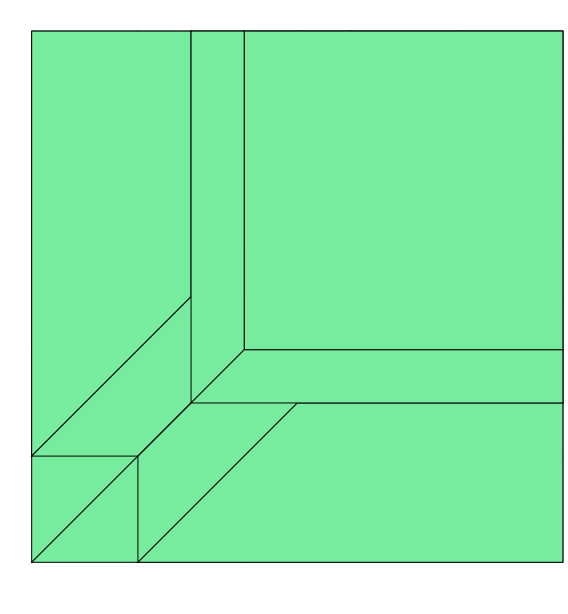

In [6]:
Polymake.display_svg(H)

polymake's bundled extension <tt>a-tint</tt> provides a function for finding lines on a tropical cubic surface.  In contrast to the classical setting there may be infinite families.

In [7]:
L = Polymake.tropical.lines_in_cubic(H.POLYNOMIAL);

@show L.N_ISOLATED
@show L.N_FAMILIES;

L.N_ISOLATED = 16
L.N_FAMILIES = 43
